<a href="https://colab.research.google.com/github/thedavidemmanuel/model-training-and-evaluation/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle

In [42]:
# Load dataset
true_news_path = '/content/drive/My Drive/Fake_News_Classification/data/True.csv'
fake_news_path = '/content/drive/My Drive/Fake_News_Classification/data/Fake.csv'

true_news = pd.read_csv(true_news_path)
fake_news = pd.read_csv(fake_news_path)

# Add labels
true_news['label'] = 1
fake_news['label'] = 0

# Combine datasets
df = pd.concat([true_news, fake_news], ignore_index=True)

In [43]:
# Preprocess Data
print("Columns in DataFrame:", df.columns)

# Handle missing values in 'text' column if it exists
if 'text' in df.columns:
    df = df.dropna(subset=['text'])
else:
    print("Column 'text' not found in DataFrame.")

# Clean and Parse the Date Strings
def parse_date(date_string):
    date_string = date_string.strip()  # Remove leading and trailing spaces
    try:
        return datetime.strptime(date_string, "%B %d, %Y")
    except ValueError:
        return pd.NaT  # Return NaT (Not a Time) for invalid date formats

# Apply the function to your DataFrame
df['date'] = df['date'].apply(parse_date)

# Extract additional features from date
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_month'] = df['date'].dt.day


Columns in DataFrame: Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')


In [45]:
# Feature engineering
df['text_length'] = df['text'].str.len()
df['title_length'] = df['title'].str.len()

# Shuffle the data
df = df.sample(frac=1, random_state=42)

# Combine title and text, giving more weight to the title
df['content'] = df['title'] + ' ' + df['title'] + ' ' + df['text']

In [49]:
# Split the data
X = df[['content', 'subject', 'text_length', 'title_length', 'day_of_week', 'month']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text data
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['content'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['content'])

# Save vectorizer
import pickle
with open('/content/drive/My Drive/Fake_News_Classification/saved_models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

In [51]:
# Define simple model
def create_simple_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

simple_news_model = create_simple_model(X_train_tfidf.shape[1])

In [52]:
# Train simple model
simple_history = simple_news_model.fit(
    X_train_tfidf.toarray(), y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=32,
    verbose=1
)

Epoch 1/10
898/898 [==============================] - 13s 14ms/step - loss: 0.0815 - accuracy: 0.9775 - val_loss: 0.0319 - val_accuracy: 0.9907
Epoch 2/10
898/898 [==============================] - 10s 12ms/step - loss: 0.0048 - accuracy: 0.9989 - val_loss: 0.0319 - val_accuracy: 0.9911
Epoch 3/10
898/898 [==============================] - 9s 10ms/step - loss: 5.8309e-04 - accuracy: 1.0000 - val_loss: 0.0323 - val_accuracy: 0.9925
Epoch 4/10
898/898 [==============================] - 10s 12ms/step - loss: 1.0476e-04 - accuracy: 1.0000 - val_loss: 0.0339 - val_accuracy: 0.9919
Epoch 5/10
898/898 [==============================] - 10s 11ms/step - loss: 4.7456e-05 - accuracy: 1.0000 - val_loss: 0.0355 - val_accuracy: 0.9922
Epoch 6/10
898/898 [==============================] - 9s 10ms/step - loss: 2.2187e-05 - accuracy: 1.0000 - val_loss: 0.0371 - val_accuracy: 0.9921
Epoch 7/10
898/898 [==============================] - 10s 11ms/step - loss: 1.0239e-05 - accuracy: 1.0000 - val_loss: 0.03

In [53]:
# Save simple model
simple_news_model.save('/content/drive/My Drive/Fake_News_Classification/saved_models/simple_news_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [54]:
# Define optimized model
def create_optimized_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,), kernel_regularizer='l2'),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer='l2'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

optimized_news_model = create_optimized_model(X_train_tfidf.shape[1])

In [55]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train optimized model
optimized_history = optimized_news_model.fit(
    X_train_tfidf.toarray(), y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Save optimized model
optimized_news_model.save('/content/drive/My Drive/Fake_News_Classification/saved_models/optimized_news_model.h5')


Epoch 1/20
898/898 [==============================] - 12s 12ms/step - loss: 0.5472 - accuracy: 0.9371 - val_loss: 0.3912 - val_accuracy: 0.9737
Epoch 2/20
898/898 [==============================] - 11s 12ms/step - loss: 0.3862 - accuracy: 0.9661 - val_loss: 0.3570 - val_accuracy: 0.9790
Epoch 3/20
898/898 [==============================] - 11s 12ms/step - loss: 0.3536 - accuracy: 0.9685 - val_loss: 0.3271 - val_accuracy: 0.9770
Epoch 4/20
898/898 [==============================] - 11s 12ms/step - loss: 0.3366 - accuracy: 0.9715 - val_loss: 0.3114 - val_accuracy: 0.9815
Epoch 5/20
898/898 [==============================] - 10s 11ms/step - loss: 0.3231 - accuracy: 0.9715 - val_loss: 0.3025 - val_accuracy: 0.9790
Epoch 6/20
898/898 [==============================] - 10s 11ms/step - loss: 0.3133 - accuracy: 0.9723 - val_loss: 0.2869 - val_accuracy: 0.9774
Epoch 7/20
898/898 [==============================] - 11s 12ms/step - loss: 0.3040 - accuracy: 0.9728 - val_loss: 0.2959 - val_accuracy:

In [56]:
# Evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test.toarray())
    pred_classes = (predictions > 0.5).astype(int)
    accuracy = accuracy_score(y_test, pred_classes)
    cm = confusion_matrix(y_test, pred_classes)
    report = classification_report(y_test, pred_classes)

    print(f"{model_name} Accuracy:", accuracy)
    print(f"{model_name} Confusion Matrix:")
    print(cm)
    print(f"{model_name} Classification Report:")
    print(report)

    return accuracy, cm, report

simple_accuracy, simple_cm, simple_report = evaluate_model(simple_news_model, X_test_tfidf, y_test, "Simple Model")
optimized_accuracy, optimized_cm, optimized_report = evaluate_model(optimized_news_model, X_test_tfidf, y_test, "Optimized Model")


281/281 [==============================] - 1s 3ms/step
Simple Model Accuracy: 0.9888641425389755
Simple Model Confusion Matrix:
[[4705   60]
 [  40 4175]]
Simple Model Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4765
           1       0.99      0.99      0.99      4215

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

281/281 [==============================] - 1s 4ms/step
Optimized Model Accuracy: 0.9804008908685968
Optimized Model Confusion Matrix:
[[4668   97]
 [  79 4136]]
Optimized Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4765
           1       0.98      0.98      0.98      4215

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted a

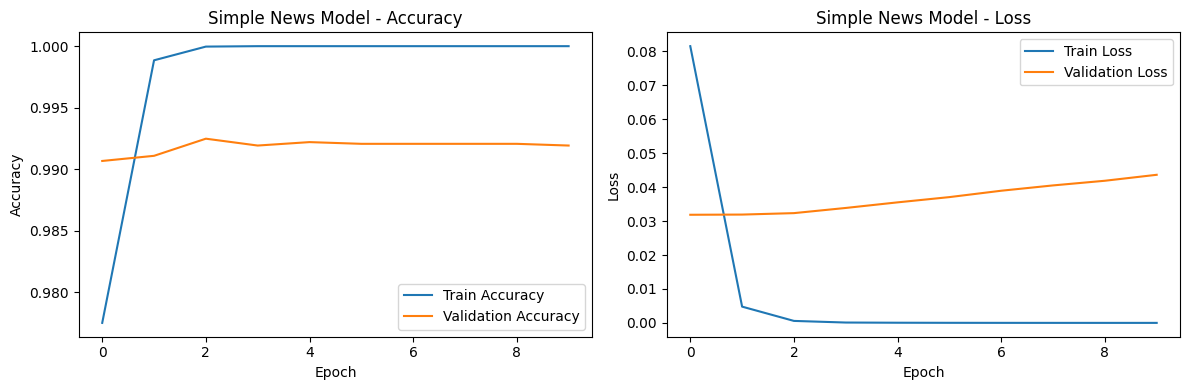

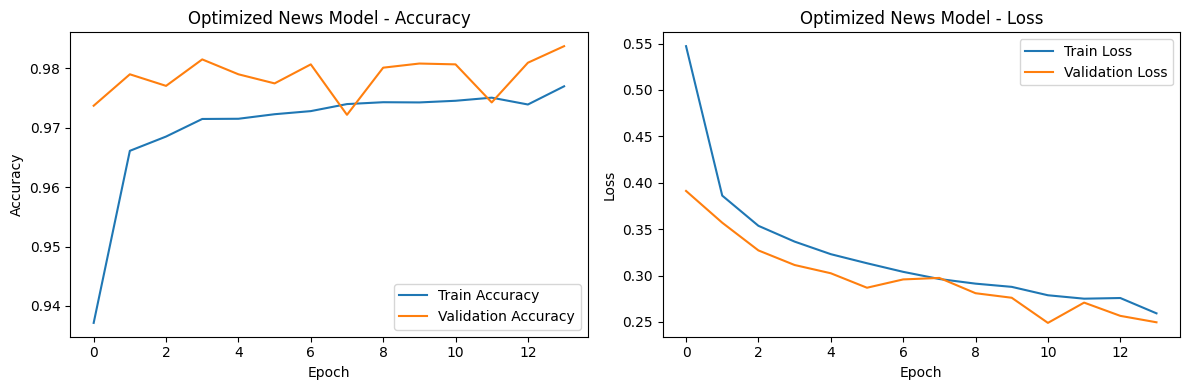

In [57]:
# Visualize the results
# Plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(122)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(simple_history, 'Simple News Model')
plot_history(optimized_history, 'Optimized News Model')


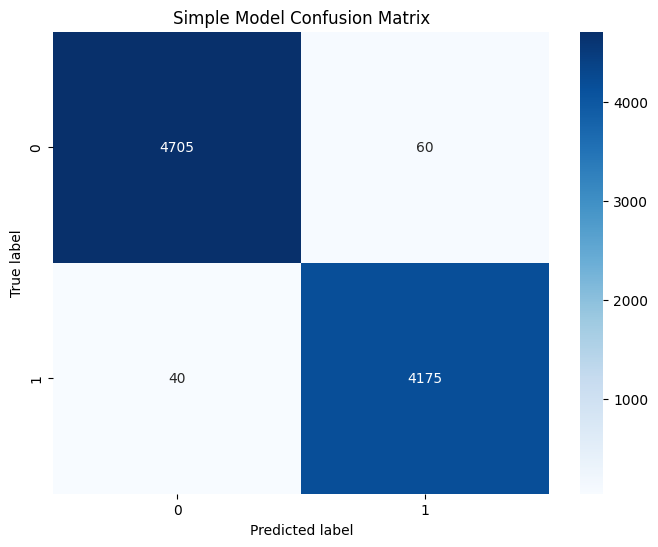

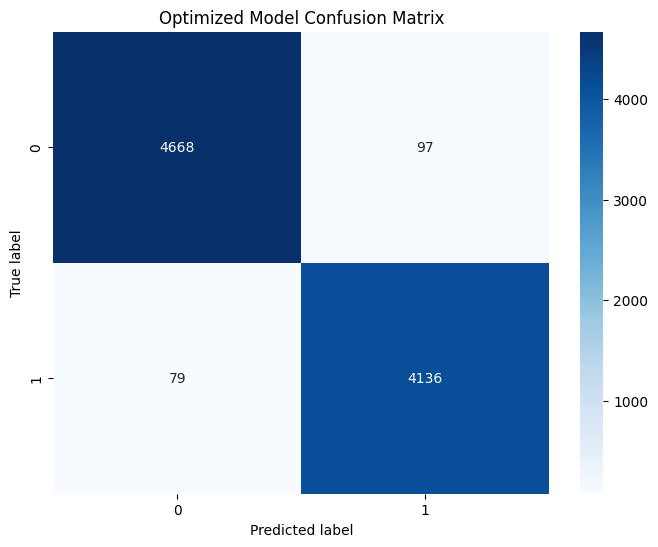

In [58]:
# Additional visualization: Confusion Matrix
# Plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(simple_cm, 'Simple Model Confusion Matrix')
plot_confusion_matrix(optimized_cm, 'Optimized Model Confusion Matrix')

In [59]:
# Print performance comparison
print("\nPerformance Comparison:")
print(f"Simple Model Accuracy: {simple_accuracy:.4f}")
print(f"Optimized Model Accuracy: {optimized_accuracy:.4f}")
print(f"Accuracy Improvement: {optimized_accuracy - simple_accuracy:.4f}")


Performance Comparison:
Simple Model Accuracy: 0.9889
Optimized Model Accuracy: 0.9804
Accuracy Improvement: -0.0085
